In [1]:
import cv2 as cv
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def capture_frame(video_dir, frame_num):
    cap = cv.VideoCapture(video_dir)
    for _ in range(frame_num):
        ret, frame = cap.read()
        if not ret:
            raise Exception(f"frame number {frame_num} out of range for video length")
        frame_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        return frame_rgb

In [3]:
# plt.imsave("upstairs1_5.png", capture_frame("upstairs1.mp4", 5))

In [4]:
image_path = "upstairs1_5.png"

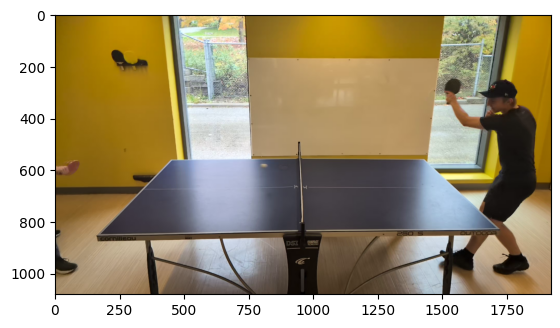

In [5]:
plt.imshow(np.array(Image.open(image_path)))

[[[ 22 122 128]
  [ 22 122 128]
  [ 22 122 128]
  ...
  [ 21 127 128]
  [ 21 127 128]
  [ 21 127 128]]

 [[ 22 122 128]
  [ 22 122 128]
  [ 22 122 128]
  ...
  [ 21 127 128]
  [ 21 127 128]
  [ 21 127 128]]

 [[ 22 122 128]
  [ 22 122 128]
  [ 22 122 128]
  ...
  [ 21 127 128]
  [ 21 127 128]
  [ 21 127 128]]

 ...

 [[ 17  46 128]
  [ 17  47 128]
  [ 17  47 128]
  ...
  [ 15  57 128]
  [ 15  57 128]
  [ 15  56 128]]

 [[ 17  46 128]
  [ 17  47 128]
  [ 17  47 128]
  ...
  [ 15  56 128]
  [ 15  56 128]
  [ 15  56 128]]

 [[ 17  46 128]
  [ 17  47 128]
  [ 17  47 128]
  ...
  [ 15  56 128]
  [ 15  56 128]
  [ 15  56 128]]]


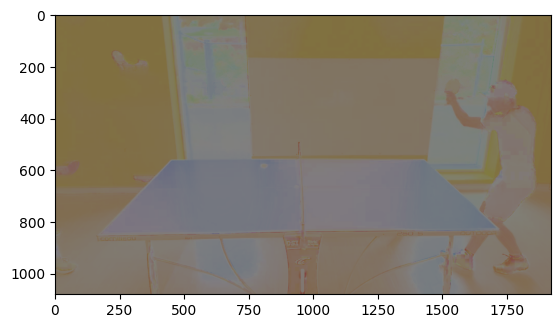

In [16]:
arr = np.array(Image.open(image_path))[:, :, :3]
hsv_arr = cv.cvtColor(arr, cv.COLOR_RGB2HSV)
hsv_arr[:, :, 1] = (hsv_arr[:, :, 1] * 0.5).astype(np.uint8)
hsv_arr[:, :, 2] = 128
print(hsv_arr)
normalized_arr = cv.cvtColor(hsv_arr, cv.COLOR_HSV2RGB)
plt.imshow(normalized_arr)

In [7]:
im = cv.imread(image_path)
assert im is not None, "file could not be read, check with os.path.exists()"
imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 100, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

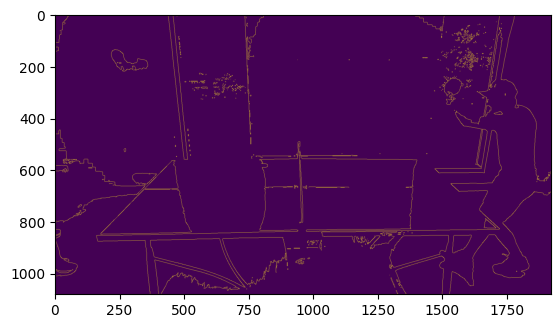

In [8]:
edges = cv.Canny(thresh, 100, 100)
plt.imshow(edges)

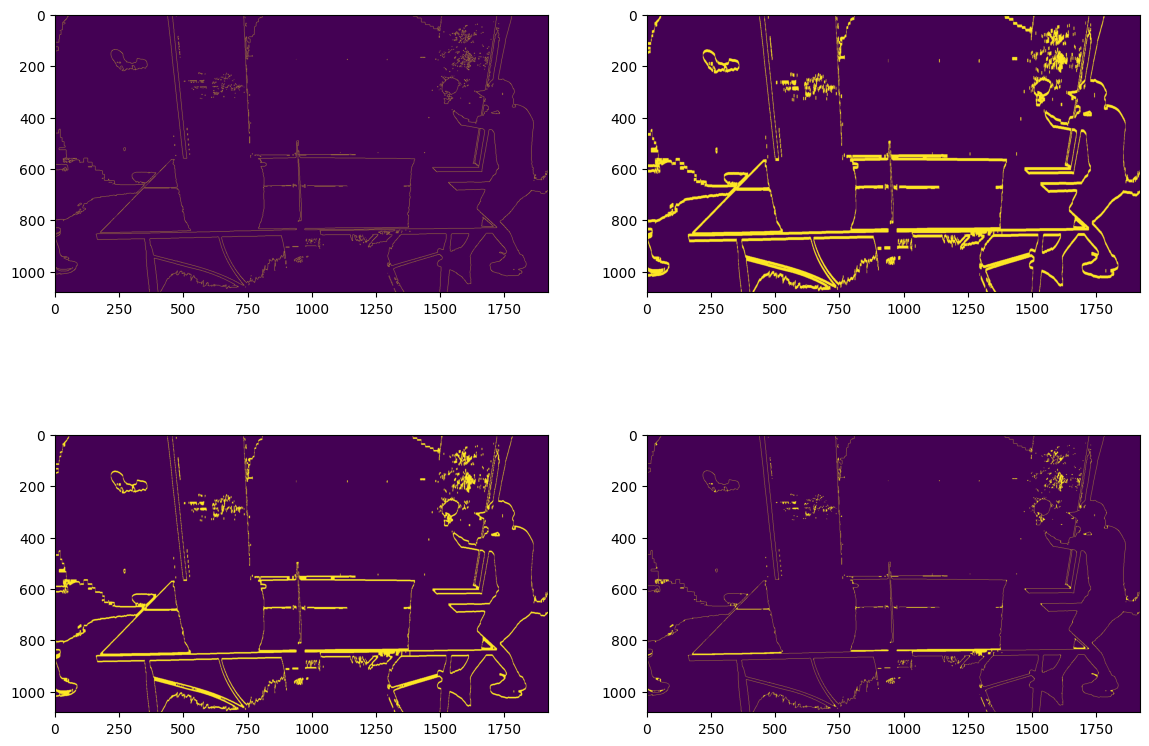

In [9]:
fig, axes = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(14)
dilated = cv.dilate(edges, (10, 10), iterations=10)
eroded = cv.erode(dilated, (3, 3), iterations=5)
closing = cv.morphologyEx(edges, cv.MORPH_CLOSE, kernel=(5, 5), iterations=5)
axes[0][0].imshow(edges)
axes[0][1].imshow(dilated)
axes[1][0].imshow(eroded)
axes[1][1].imshow(closing)
fig.show()

In [10]:
import math
# Dubious class from Stack Overflow

class HoughBundler:     
    def __init__(self,min_distance=5,min_angle=2):
        self.min_distance = min_distance
        self.min_angle = min_angle
    
    def get_orientation(self, line):
        orientation = math.atan2(abs((line[3] - line[1])), abs((line[2] - line[0])))
        return math.degrees(orientation)

    def check_is_line_different(self, line_1, groups, min_distance_to_merge, min_angle_to_merge):
        for group in groups:
            for line_2 in group:
                if self.get_distance(line_2, line_1) < min_distance_to_merge:
                    orientation_1 = self.get_orientation(line_1)
                    orientation_2 = self.get_orientation(line_2)
                    if abs(orientation_1 - orientation_2) < min_angle_to_merge:
                        group.append(line_1)
                        return False
        return True

    def distance_point_to_line(self, point, line):
        px, py = point
        x1, y1, x2, y2 = line

        def line_magnitude(x1, y1, x2, y2):
            line_magnitude = math.sqrt(math.pow((x2 - x1), 2) + math.pow((y2 - y1), 2))
            return line_magnitude

        lmag = line_magnitude(x1, y1, x2, y2)
        if lmag < 0.00000001:
            distance_point_to_line = 9999
            return distance_point_to_line

        u1 = (((px - x1) * (x2 - x1)) + ((py - y1) * (y2 - y1)))
        u = u1 / (lmag * lmag)

        if (u < 0.00001) or (u > 1):
            #// closest point does not fall within the line segment, take the shorter distance
            #// to an endpoint
            ix = line_magnitude(px, py, x1, y1)
            iy = line_magnitude(px, py, x2, y2)
            if ix > iy:
                distance_point_to_line = iy
            else:
                distance_point_to_line = ix
        else:
            # Intersecting point is on the line, use the formula
            ix = x1 + u * (x2 - x1)
            iy = y1 + u * (y2 - y1)
            distance_point_to_line = line_magnitude(px, py, ix, iy)

        return distance_point_to_line

    def get_distance(self, a_line, b_line):
        dist1 = self.distance_point_to_line(a_line[:2], b_line)
        dist2 = self.distance_point_to_line(a_line[2:], b_line)
        dist3 = self.distance_point_to_line(b_line[:2], a_line)
        dist4 = self.distance_point_to_line(b_line[2:], a_line)

        return min(dist1, dist2, dist3, dist4)

    def merge_lines_into_groups(self, lines):
        groups = []  # all lines groups are here
        # first line will create new group every time
        groups.append([lines[0]])
        # if line is different from existing gropus, create a new group
        for line_new in lines[1:]:
            if self.check_is_line_different(line_new, groups, self.min_distance, self.min_angle):
                groups.append([line_new])

        return groups

    def merge_line_segments(self, lines):
        orientation = self.get_orientation(lines[0])
      
        if(len(lines) == 1):
            return np.block([[lines[0][:2], lines[0][2:]]])

        points = []
        for line in lines:
            points.append(line[:2])
            points.append(line[2:])
        if 45 < orientation <= 90:
            #sort by y
            points = sorted(points, key=lambda point: point[1])
        else:
            #sort by x
            points = sorted(points, key=lambda point: point[0])

        return np.block([[points[0],points[-1]]])

    def process_lines(self, lines):
        lines_horizontal  = []
        lines_vertical  = []
  
        for line_i in [l[0] for l in lines]:
            orientation = self.get_orientation(line_i)
            # if vertical
            if 45 < orientation <= 90:
                lines_vertical.append(line_i)
            else:
                lines_horizontal.append(line_i)

        lines_vertical  = sorted(lines_vertical , key=lambda line: line[1])
        lines_horizontal  = sorted(lines_horizontal , key=lambda line: line[0])
        merged_lines_all = []

        # for each cluster in vertical and horizantal lines leave only one line
        for i in [lines_horizontal, lines_vertical]:
            if len(i) > 0:
                groups = self.merge_lines_into_groups(i)
                merged_lines = []
                for group in groups:
                    merged_lines.append(self.merge_line_segments(group))
                merged_lines_all.extend(merged_lines)
                    
        return np.asarray(merged_lines_all)

In [11]:
def detect_lines(image_dir):
    im = cv.imread(image_dir)
    assert im is not None, "file could not be read, check with os.path.exists()"
    imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(imgray, 200, 255, 0)
    # contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    edges = cv.Canny(thresh, 200, 250)
    edges = cv.dilate(edges, (10, 10), iterations=10)
    # edges = cv.erode(dilated, (3, 3), iterations=5)

    linesP = cv.HoughLinesP(edges, 1, np.pi / 180, 200, None, 200, 5)
    linesP = HoughBundler().process_lines(linesP)
    linesP = np.array(linesP).reshape(-1, 4)
    return linesP    

In [12]:
def load_numpy(image_dir):
    return np.array(Image.open(image_dir))

In [13]:
linesP = detect_lines(image_path)
print(np.array(linesP).shape)
print(linesP)
print(f"Detected {len(linesP)} lines")
color_image = load_numpy(image_path) / 255 / 4
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i]
        
        cv.line(color_image, (l[0], l[1]), (l[2], l[3]), np.random.rand(3), 3, cv.LINE_AA)

(4, 4)
[[486 140 738 116]
 [507 341 753 368]
 [528 326 753 356]
 [430 157 473 572]]
Detected 4 lines


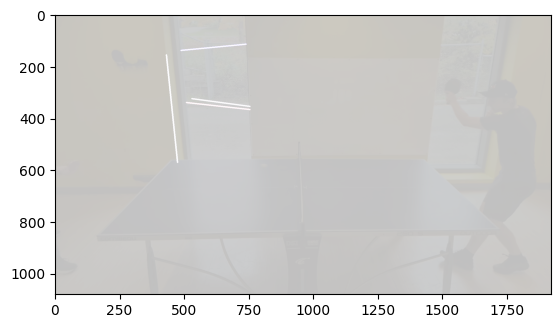

In [14]:
plt.imshow(color_image)

In [15]:
from scipy.spatial.distance import pdist, squareform

starts = linesP[:, :2]
ends = linesP[:, 2:]
endpoints = np.concatenate((starts, ends))
distances = squareform(pdist(endpoints))
print(distances.shape)
distances[np.linspace(0, distances.shape[0] - 1, distances.shape[0]), np.linspace(0, distances.shape[1] - 1, distances.shape[1])] = np.max(distances)
plt.imshow(distances, cmap='gray')

(8, 8)


IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
np.linspace(0, 9, 10).astype(int)